In [1]:
import numpy as np
import pandas as pd
import keras 
import os
import time
import sys
import tensorflow as tf

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage import io

from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image

from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from numpy import array
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### Data is downloaded from kaggle: 

In [3]:
df_train = pd.read_csv('C:\\diabetic-retinopathy-detection\\trainlabels\\trainLabels.csv')

### Lets take a look at all the labels. '10_left' is a name of the file whereas '0/1/2/3/4' are the labels '10_left' image of the left eye '10_right' image of the right eye for the same person

In [4]:
df_train.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [5]:
df_train.tail()

,image,level
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0
35125,44349_right,1


In [6]:
targets_series = pd.Series(df_train['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)

### There are 5 types of labels 0/1/2/3/4, thry are distinguished as below 
### NDPR - Non Proliferative Diabetic Retinopathy
### Class Name 0 Normal
### 1 Mild NPDR 2 Moderate NPDR 3 Severe NPDR
### 4 PDR

In [7]:
one_hot_labels = np.asarray(one_hot)

In [8]:
one_hot_labelsY = np.asarray(targets_series)

In [9]:
one_hot_labelsY[:10]

array([0, 0, 0, 0, 1, 2, 4, 4, 0, 1], dtype=int64)

In [10]:
x_train = []
y_train = []
x_test = []

In [11]:
df_test = []

In [12]:
i=0
for f, breed in tqdm(df_train.values):
    try:
        img = image.load_img(('C:\\diabetic-retinopathy-detection\\trainlabels\\train_new\\{}.jpeg'.format(f)), target_size=(128, 128))
        arr = image.img_to_array(img)
        label = one_hot_labelsY[i]
        x_train.append(arr)
        y_train.append(label)
        i += 1 
    except:
        pass

100%|██████████| 35126/35126 [01:40<00:00, 350.14it/s]


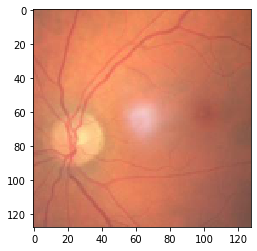

In [13]:
from matplotlib import pyplot as plt
plt.imshow(x_train[10011]/255)
plt.show()

In [17]:
x_valid = []
y_valid = []

In [18]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [19]:
y_train_raw = np.array(Y_train)

In [20]:
x_train_raw = np.array(X_train)

In [21]:
y_train_raw.shape

(31613,)

In [22]:
x_train_raw.shape

(31613, 128, 128, 3)

In [30]:
batch_size = 1000
nb_classes = 5
nb_epoch = 5

img_rows, img_cols = 128, 128
channels = 3
nb_filters = 32
kernel_size = (8,8)
model = Sequential()
model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1]),

padding='valid',

strides=4,

input_shape=(img_rows, img_cols, channels)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (4, 4)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
print("Model flattened out to: ", model.output_shape)
model.add(Dense(128))
model.add(Activation('sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(nb_classes))

model.add(Activation('softmax'))
model.summary()

Model flattened out to:  (None, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 31, 32)        6176      
_________________________________________________________________
activation_21 (Activation)   (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 32)        65568     
_________________________________________________________________
activation_22 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 17, 17, 32)        65568     
_________________________________________________________________
activation_23 (Activation)   (None, 17, 17, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 

In [32]:
from keras import optimizers
opt = optimizers.adam(lr=0.001, decay=0.0)
model.compile(optimizer= opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
stop = EarlyStopping(monitor='val_acc',
                            min_delta=0.001,
                            patience=2,
                            verbose=0,
                            mode='auto')
tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

with tf.device('/device:GPU:0'):
    model.fit(x_train_raw, y_train_raw, batch_size=batch_size, epochs=nb_epoch,
                verbose=1,
                callbacks=[stop, tensor_board])

Epoch 1/5
31613/31613 [==============================] - ETA: 6:12 - loss: 0.9640 - acc: 0.708 - ETA: 5:43 - loss: 0.9489 - acc: 0.716 - ETA: 5:23 - loss: 0.9413 - acc: 0.714 - ETA: 5:08 - loss: 0.9299 - acc: 0.722 - ETA: 4:57 - loss: 0.9242 - acc: 0.725 - ETA: 4:44 - loss: 0.9261 - acc: 0.726 - ETA: 4:31 - loss: 0.9151 - acc: 0.730 - ETA: 4:19 - loss: 0.9161 - acc: 0.730 - ETA: 4:01 - loss: 0.9118 - acc: 0.731 - ETA: 3:38 - loss: 0.9088 - acc: 0.732 - ETA: 3:21 - loss: 0.9121 - acc: 0.731 - ETA: 3:12 - loss: 0.9084 - acc: 0.732 - ETA: 3:03 - loss: 0.9099 - acc: 0.731 - ETA: 2:53 - loss: 0.9082 - acc: 0.731 - ETA: 2:45 - loss: 0.9060 - acc: 0.733 - ETA: 2:36 - loss: 0.9073 - acc: 0.732 - ETA: 2:26 - loss: 0.9098 - acc: 0.732 - ETA: 2:17 - loss: 0.9124 - acc: 0.731 - ETA: 2:08 - loss: 0.9170 - acc: 0.730 - ETA: 1:58 - loss: 0.9199 - acc: 0.729 - ETA: 1:48 - loss: 0.9202 - acc: 0.729 - ETA: 1:38 - loss: 0.9186 - acc: 0.730 - ETA: 1:27 - loss: 0.9190 - acc: 0.730 - ETA: 1:17 - loss: 0.915

C:\Users\yogit\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/5
31613/31613 [==============================] - ETA: 5:41 - loss: 0.9524 - acc: 0.701 - ETA: 4:40 - loss: 0.9163 - acc: 0.719 - ETA: 4:42 - loss: 0.9324 - acc: 0.718 - ETA: 4:41 - loss: 0.9348 - acc: 0.718 - ETA: 4:33 - loss: 0.9303 - acc: 0.719 - ETA: 4:25 - loss: 0.9227 - acc: 0.723 - ETA: 4:18 - loss: 0.9199 - acc: 0.726 - ETA: 4:08 - loss: 0.9209 - acc: 0.726 - ETA: 3:56 - loss: 0.9192 - acc: 0.726 - ETA: 3:48 - loss: 0.9187 - acc: 0.727 - ETA: 3:37 - loss: 0.9143 - acc: 0.729 - ETA: 3:27 - loss: 0.9166 - acc: 0.729 - ETA: 3:17 - loss: 0.9140 - acc: 0.730 - ETA: 3:07 - loss: 0.9104 - acc: 0.731 - ETA: 2:56 - loss: 0.9115 - acc: 0.730 - ETA: 2:46 - loss: 0.9102 - acc: 0.731 - ETA: 2:36 - loss: 0.9099 - acc: 0.731 - ETA: 2:25 - loss: 0.9093 - acc: 0.731 - ETA: 2:16 - loss: 0.9092 - acc: 0.731 - ETA: 2:05 - loss: 0.9081 - acc: 0.731 - ETA: 1:54 - loss: 0.9076 - acc: 0.731 - ETA: 1:43 - loss: 0.9071 - acc: 0.731 - ETA: 1:33 - loss: 0.9081 - acc: 0.731 - ETA: 1:22 - loss: 0.908

In [36]:
x_valid_raw = np.array(X_valid)
y_valid_raw = np.array(Y_valid)

In [37]:
test_loss, test_acc = model.evaluate(x_valid_raw, y_valid_raw)

3513/3513 [==============================] - ETA: 17 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 14s 4ms/step


In [38]:
test_loss

0.8404576511522863

In [39]:
test_acc

0.7466552804719679

In [40]:
print("Predicting")
y_pred = model.predict(x_valid_raw)
score = model.evaluate(x_valid_raw, y_valid_raw, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
y_pred = [np.argmax(y) for y in y_pred]
y_test = [np.argmax(y) for y in y_valid_raw]

precision = precision_score(y_test, y_pred, average='weighted')

recall = recall_score(y_test, y_pred, average='weighted')

print("Precision: ", precision)

print("Recall: ", recall)

Predicting
Test score: 0.8404576511522863
Test accuracy: 0.7466552804719679
Precision:  1.0
Recall:  1.0
